# Using a variational autoencoder (VAE) to create new faces
This notebook is hevily based on this work: [Generating new faces using VAE](https://www.kaggle.com/code/mohammed165/generating-new-faces-using-vae).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    optimizers,
)

from scipy.stats import norm
import pandas as pd

import keras
from keras import losses

In [2]:
%%time

IMAGE_SIZE = 256 
CHANNELS = 3
BATCH_SIZE = 128
Z_DIM = 200
BETA = 2000
LOAD_MODEL = False

train_data = utils.image_dataset_from_directory(
    "/kaggle/input/50k-celebrity-faces-image-dataset/Celebrity_Faces_Dataset",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 50000 files.
CPU times: user 3.25 s, sys: 2.06 s, total: 5.31 s
Wall time: 54.7 s


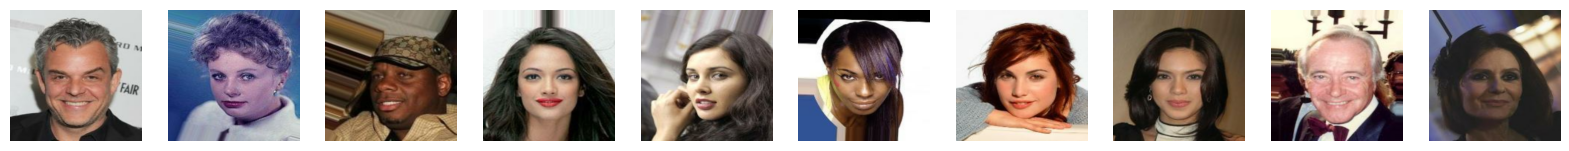

In [3]:
# Preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img
    
def sample(data):
  batch = data.take(1).get_single_element()
  if isinstance(batch , tuple):
    batch = batch[0]
  return batch.numpy()
    
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

train = train_data.map(lambda x: preprocess(x))

sample = sample(train)
display(sample)

In [4]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# The encoder

In [5]:
n_filters = 128

In [6]:
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(n_filters, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(n_filters, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(n_filters, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(n_filters, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(n_filters, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

# The decoder

In [7]:
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    n_filters, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    n_filters, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    n_filters, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    n_filters, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    n_filters, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)

# The VAE

In [8]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * keras.losses.MeanSquaredError(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

vae = VAE(encoder , decoder)

In [9]:
LEARNING_RATE = 0.0005

optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [10]:
# callback
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("/kaggle/working/generated_img_%03d_%d.png" % (epoch, i))

# Fit (train)

In [11]:
%%time

EPOCHS = 25

vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[ImageGenerator(num_img=10, latent_dim=Z_DIM)]
)

Epoch 1/25


I0000 00:00:1732948990.675338      77 service.cc:145] XLA service 0x7ca8440892f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732948990.675425      77 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732948990.675430      77 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-11-30 06:43:26.594699: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng2{k2=1,k3=0} for conv (f32[128,128,257,257]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-30 06:43:27.044113: E externa

390/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - kl_loss: 10.4260 - loss: 122.2269 - reconstruction_loss: 111.8010

2024-11-30 06:55:00.792382: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=2} for conv (f32[80,128,129,129]{3,2,1,0}, u8[0]{0}) custom-call(f32[80,128,64,64]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-30 06:55:01.257560: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.465309896s
Trying algorithm eng4{k11=2} for conv (f32[80,128,129,129]{3,2,1,0}, u8[0]{0}) custom-call(f32[80,128,64,64]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],

391/391 ━━━━━━━━━━━━━━━━━━━━ 762s 2s/step - kl_loss: 10.4483 - loss: 122.1089 - reconstruction_loss: 111.6606
Epoch 2/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 642s 2s/step - kl_loss: 17.6318 - loss: 77.8751 - reconstruction_loss: 60.2434
Epoch 3/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 642s 2s/step - kl_loss: 17.7966 - loss: 68.6731 - reconstruction_loss: 50.8766
Epoch 4/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 641s 2s/step - kl_loss: 17.8657 - loss: 67.0103 - reconstruction_loss: 49.1446
Epoch 5/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 641s 2s/step - kl_loss: 18.0180 - loss: 66.3086 - reconstruction_loss: 48.2906
Epoch 6/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 641s 2s/step - kl_loss: 18.0377 - loss: 65.7775 - reconstruction_loss: 47.7398
Epoch 7/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 640s 2s/step - kl_loss: 18.0910 - loss: 65.1900 - reconstruction_loss: 47.0990
Epoch 8/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 642s 2s/step - kl_loss: 18.2169 - loss: 64.9450 - reconstruction_loss: 46.7281
Epoch 9/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 642s 2s/step - kl

# Predict

In [12]:
grid_width, grid_height = (3, 10)

z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))
reconstructions = decoder.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


# Results

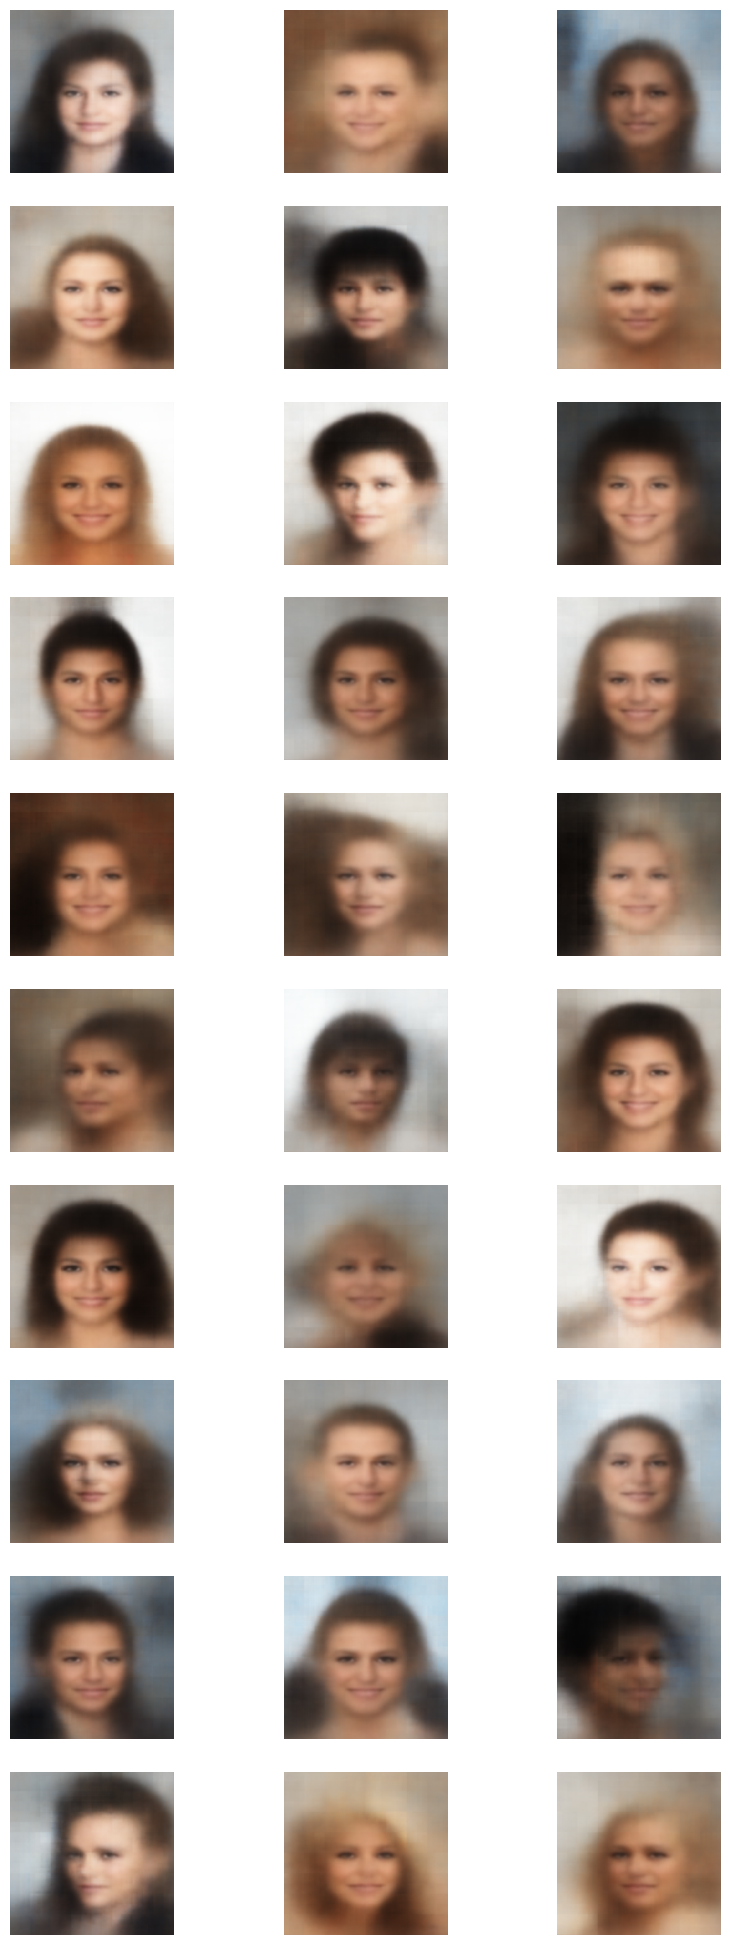

In [13]:
fig = plt.figure(figsize=(10, 25))
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])